In [1]:
import math
import warnings

import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn import linear_model
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, kstest, boxcox
%matplotlib inline

import itertools
from itertools import chain, combinations
import scipy.stats as scipystats
import statsmodels.api as sm
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats 
from statsmodels.graphics.regressionplots import *
import copy
from sklearn.cross_validation import train_test_split
import time

pd.options.display.float_format = '{:,.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

/usr/local/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Grab and process the raw data.
# https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls

data_path = ("Unit_2-Supporting_Files/table_8_offenses_known_to_law_enforcement_new_york_by_city_2014.csv"
            )
df_raw = pd.read_csv(data_path, delimiter= ',')

In [3]:
df_raw.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Unnamed: 13
0,Adams Village,"1,851",0,0.000,NaN,0.000,0,0,11,1,10,0,0.000,nan
1,Addison Town and Village,"2,568",2,0.000,NaN,0.000,1,1,49,1,47,1,0.000,nan
2,Afton Village4,820,0,0.000,0,nan,0,0,1,0,1,0,0.000,nan
3,Akron Village,"2,842",1,0.000,NaN,0.000,0,1,17,0,17,0,0.000,nan
4,Albany4,"98,595",802,8.000,54,nan,237,503,"3,888",683,"3,083",122,12.000,nan


In [4]:
df_raw.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3', 'Unnamed: 13'],
      dtype='object')

In [5]:
# Create new df and Remove 3 unwanted columns and rows.
df = df_raw.drop(['Rape\n(revised\ndefinition)1','Rape\n(legacy\ndefinition)2','Unnamed: 13', 'Arson3'], axis=1).drop(df_raw.index[-3:]).copy()

In [6]:
# Make a dataframe copy and rename columns
df.rename(columns={'Violent\ncrime':'Violence',
                            'Murder and\nnonnegligent\nmanslaughter':'Murder',
                            'Aggravated\nassault':'Assault',
                            'Property\ncrime':'Prop_Crime',
                            'Larceny-\ntheft':'Theft',
                            'Motor\nvehicle\ntheft':'MV_Theft'}, inplace=True)

In [7]:
# Drop NaNs
df = df.dropna()

In [8]:
#Pop size squared:

## Remove commas in pop size and robbery numericals
df['Population'] = df.Population.str.replace(',', '')
df['Violence'] = df.Violence.str.replace(',', '')
df['Robbery'] = df.Robbery.str.replace(',', '')
df['Assault'] = df.Assault.str.replace(',', '')
df['Prop_Crime'] = df.Prop_Crime.str.replace(',', '')
df['Burglary'] = df.Burglary.str.replace(',', '')
df['Theft'] = df.Theft.str.replace(',', '')
df['MV_Theft'] = df.MV_Theft.str.replace(',', '')
df['City'] = df.City.str.replace('4', '')

## Convert type to int (from string)
df['Population'] = df.Population.astype(int)
df['Violence'] = df.Violence.astype(int)
df['Murder'] = df.Murder.astype(int)
df['Assault'] = df.Assault.astype(int)
df['Robbery'] = df.Robbery.astype(int)
df['Prop_Crime'] = df.Prop_Crime.astype(int)
df['Burglary'] = df.Burglary.astype(int)
df['Theft'] = df.Theft.astype(int)
df['MV_Theft'] = df.MV_Theft.astype(int)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368 entries, 0 to 368
Data columns (total 10 columns):
City          368 non-null object
Population    368 non-null int64
Violence      368 non-null int64
Murder        368 non-null int64
Robbery       368 non-null int64
Assault       368 non-null int64
Prop_Crime    368 non-null int64
Burglary      368 non-null int64
Theft         368 non-null int64
MV_Theft      368 non-null int64
dtypes: int64(9), object(1)
memory usage: 31.6+ KB


In [10]:
# Create new features: murder to categorical, robbery to catgorical
df['Murder_feat'] = np.where((df['Murder']==0), 0, 1)
df['Robbery_feat'] = np.where((df['Robbery']==0), 0, 1)

## Square & Square Root the Population
df['Population_Sq_feat'] = df.Population * df.Population
df['Population_Sqrt_feat'] = [math.sqrt(x) for x in df.Population]

In [11]:
df[['City','Population','Population_Sq_feat','Prop_Crime']].sort_values('Prop_Crime', ascending=False).head()

,City,Population,Population_Sq_feat,Prop_Crime
227,New York,8473938,71807625227844,135747
38,Buffalo,258419,66780379561,12449
283,Rochester,210347,44245860409,8856
326,Syracuse,144534,20890077156,5755
4,Albany,98595,9720974025,3888


In [12]:
# Create variable that drops an outlier to compare against raw.
df_drop_nyc =  df[df.City != 'New York']

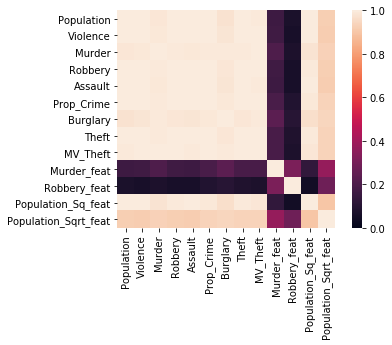

                      Population  Violence  Murder  Robbery  Assault  \
Population                 1.000     0.999   0.985    0.998    0.999   
Violence                   0.999     1.000   0.991    1.000    1.000   
Murder                     0.985     0.991   1.000    0.993    0.989   
Robbery                    0.998     1.000   0.993    1.000    1.000   
Assault                    0.999     1.000   0.989    1.000    1.000   
Prop_Crime                 0.996     0.998   0.995    0.998    0.997   
Burglary                   0.977     0.983   0.996    0.985    0.981   
Theft                      0.998     0.999   0.992    0.999    0.998   
MV_Theft                   0.993     0.996   0.998    0.997    0.995   
Murder_feat                0.163     0.165   0.205    0.168    0.161   
Robbery_feat               0.072     0.065   0.076    0.066    0.063   
Population_Sq_feat         0.998     0.997   0.978    0.995    0.998   
Population_Sqrt_feat       0.924     0.922   0.930    0.924    0

In [13]:
corrmat = df.corr()
corrmat_drop_nyc = df_drop_nyc.corr()

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmin=0, vmax=1, square=True)
plt.show()

print(corrmat)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


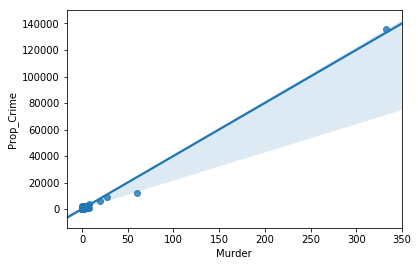

In [14]:
sns.regplot(df.Murder, df.Prop_Crime)

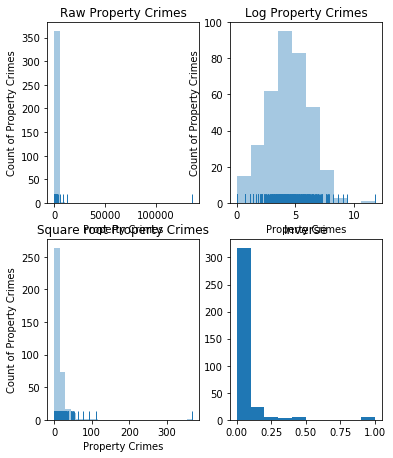

In [15]:
# Checking out the distribution of the independent variable: TV
fig = plt.figure()
plt.subplots_adjust(left=None, bottom=-.5, right=None, top=None, wspace=None, hspace=None)

fig.add_subplot(221)
sns.distplot(df['Prop_Crime'], kde=False, rug=True, bins=25)
plt.title('Raw Property Crimes')
plt.xlabel('Property Crimes')
plt.ylabel('Count of Property Crimes')

fig.add_subplot(222)
sns.distplot(np.log(df['Prop_Crime'][df.Prop_Crime != 0]),kde=False, rug=True, bins=10)
plt.title('Log Property Crimes')
plt.xlabel('Property Crimes')
plt.ylabel('Count of Property Crimes')

fig.add_subplot(223)
sns.distplot(np.sqrt(df['Prop_Crime']),kde=False, rug=True, bins=25)
plt.title('Square root Property Crimes')
plt.xlabel('Property Crimes')
plt.ylabel('Count of Property Crimes')

# ax3=fig.add_subplot(224)
# Box Cox Transformation:
# http://www.kmdatascience.com/2017/07/box-cox-transformations-in-python.html

# Transform_Prop_Crime = np.asarray(df['Prop_Crime'][df.Prop_Crime != 0].values)

# # transform values and store as "sales_boxcox"
# Prop_Crime_boxcox = boxcox(Transform_Prop_Crime)[0]

# # # create the boxcox_sales transformed variable:
# df['Prop_Crime_boxcox'] = Prop_Crime_boxcox

# print(df.Prop_Crime_boxcox.unique())

# # plot the transformed box cox data
ax3=fig.add_subplot(224)
plt.hist(1/df['Prop_Crime'][df.Prop_Crime != 0])
plt.title('Inverse')
plt.show()

# plt.show()

In [16]:
# In order to use log, we must know if there's a significant count of instances of 
print('Count of cities w/ 0 Property Crimes:\n',(df['Prop_Crime'] == 0).sum())

Count of cities w/ 0 Property Crimes:
 6


In [17]:
# Only Drop 6 observations, which is an immaterial amount. Will drop these observations
# and Transform the variable
df_drop_zero = df[df.Prop_Crime != 0]
df_drop_nyc_zero = df_drop_nyc[df_drop_nyc.Prop_Crime != 0]
# Add new feature
df_drop_zero['Prop_Crime_log'] = np.log(df_drop_zero['Prop_Crime'])
df_drop_nyc_zero['Prop_Crime_log'] = np.log(df_drop_nyc_zero['Prop_Crime'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [18]:
df_drop_zero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 0 to 368
Data columns (total 15 columns):
City                    362 non-null object
Population              362 non-null int64
Violence                362 non-null int64
Murder                  362 non-null int64
Robbery                 362 non-null int64
Assault                 362 non-null int64
Prop_Crime              362 non-null int64
Burglary                362 non-null int64
Theft                   362 non-null int64
MV_Theft                362 non-null int64
Murder_feat             362 non-null int64
Robbery_feat            362 non-null int64
Population_Sq_feat      362 non-null int64
Population_Sqrt_feat    362 non-null float64
Prop_Crime_log          362 non-null float64
dtypes: float64(2), int64(12), object(1)
memory usage: 45.2+ KB


Coefficients
 Intercept   4.366
Murder      0.028
dtype: float64 

P Values
 Intercept   0.000
Murder      0.000
dtype: float64 

R Squared
 0.07789782002812351 

Confidence Intervals
               0     1
Intercept 4.188 4.544
Murder    0.018 0.038


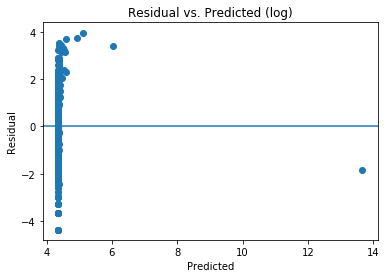

In [19]:
lm_all = smf.ols(formula = "Prop_Crime_log ~ Murder", data = df_drop_zero).fit()

print('Coefficients\n',lm_all.params,'\n')
print('P Values\n',lm_all.pvalues,'\n')
print('R Squared\n',lm_all.rsquared,'\n')
print('Confidence Intervals\n',lm_all.conf_int())

resid = lm_all.resid
plt.scatter(lm_all.predict(), resid)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted (log)')
plt.show()

Coefficients
 Intercept   4.215
Assault     0.006
dtype: float64 

P Values
 Intercept   0.000
Assault     0.000
dtype: float64 

R Squared
 0.18004680686852126 

Confidence Intervals
               0     1
Intercept 4.047 4.384
Assault   0.005 0.008


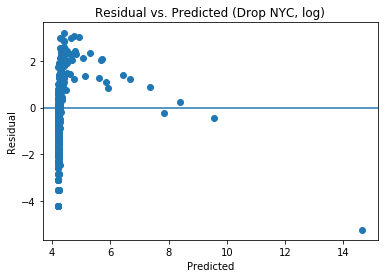

In [20]:
lm_drop_nyc = smf.ols(formula = "Prop_Crime_log ~ Assault", data = df_drop_nyc_zero).fit()

print('Coefficients\n',lm_drop_nyc.params,'\n')
print('P Values\n',lm_drop_nyc.pvalues,'\n')
print('R Squared\n',lm_drop_nyc.rsquared,'\n')
print('Confidence Intervals\n',lm_drop_nyc.conf_int())

resid = lm_drop_nyc.resid
plt.scatter(lm_drop_nyc.predict(), resid)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted (Drop NYC, log)')
plt.show()

Coefficients
 Intercept   202.823
Violence      2.691
dtype: float64 

P Values
 Intercept   0.000
Violence    0.000
dtype: float64 

R Squared
 0.996036827927479 

Confidence Intervals
                 0       1
Intercept 156.677 248.969
Violence    2.673   2.708


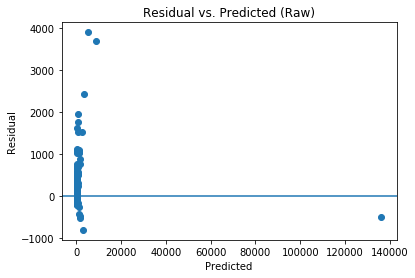

In [63]:
lm = smf.ols(formula = "Prop_Crime ~ Violence", data = df).fit()

print('Coefficients\n',lm.params,'\n')
print('P Values\n',lm.pvalues,'\n')
print('R Squared\n',lm.rsquared,'\n')
print('Confidence Intervals\n',lm.conf_int())

resid = lm.resid
plt.scatter(lm.predict(), resid)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted (Raw)')
plt.show()

In [64]:
print(lm.summary())
elem1res = pd.concat([df, pd.Series(lm.resid, name = 'resid'), pd.Series(lm.predict(), name = "predict")], axis = 1)

                            OLS Regression Results                            
Dep. Variable:             Prop_Crime   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 9.198e+04
Date:                Sun, 18 Nov 2018   Prob (F-statistic):               0.00
Time:                        18:04:52   Log-Likelihood:                -2768.6
No. Observations:                 368   AIC:                             5541.
Df Residuals:                     366   BIC:                             5549.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    202.8229     23.466      8.643      0.0

### Writeup

#### Assumption one: linear relationship
Using the raw variables Violence produce an R-Squared of 99.6% and thus, virtually all of the variance Property Crimes.

Looking at the coefficients, there's a intercept of 202.8, which indicates that Property Crimes would happen with the other Violent crimes happening. Violence has the Property Crime increase on with 2.69 per Property Crime.

Due to the accuracy of the raw variables, engineering additional features would would yield minimal value.

#### Assumption two: multivariate normality
The error from the model (calculated by subtracting the model-predicted values from the real outcome values) should is normally distributed, with a very high reversion to the mean.

Initially, despite the City of New York being an large outlier, it actually maps well along the line of best fit amongst the different crime variables. Dropping New York actually resulted in less accuracy and weaker linear relationship.

I tried transforming the data to log, however this drastically reduced the R sq and confidence intervals, which made the regression unusable.

While transforming the data to log more evenly distributes the data, the raw distribution is sufficient enough, with an understanding of the high reversion to the mean. There is a risk over overfitting.

#### Assumption three: homoscedasticity
At first glance, the errors seem to not be consistently distributed. The scale of the scatter plot is framing this view, and removing NYC illustrates that the rest of the data is more consistently distributed.

The larger value of NYC is still consistent with the other errors, however just much larger.

The homoscedasticity is best distributed with Violence, however the graph could certainly be better scattered.

#### Assumption four: low multicollinearity¶
Only one variable is used, resulting in no multicollinearity.